<a href="https://colab.research.google.com/github/kerryback/2022-BUSI520/blob/main/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# uncomment the following line if plotly is not installed
# !pip install plotly

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

# one of several possible seaborn style choices (or omit altogether)
sns.set_style('whitegrid')

### Get wage dataset used in Wooldridge's Introductory Econometrics

 We read the Stata dta file into a StataReader object that contains the data (use .read()) and the description of the variables (use .variable_labels()).  Instead of using urlopen, ZipFile, and BytesIO, we could instead go to the website in a browser, download the zip file to disk, and extract and read the dta file from disk with pd.read_stata.

In [62]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
    
url = urlopen("https://www.cengage.com/aise/economics/wooldridge_3e_datasets/statafiles.zip")

with ZipFile(BytesIO(url.read())) as zipped:
    file = zipped.open("WAGE1.DTA")
    stata = pd.read_stata(file, iterator=True)

Uncomment lines or groups of lines and execute the cells.  Single lines are commented with #.  Groups of lines are commented with triple quotes.

In [63]:
# stata.variable_labels()

In [64]:
wages = stata.read()

### Info about the dataset



In [65]:
# wages.info()
# wages.describe()
# wages[wages.female==1].describe()
# wages[wages.female==0].describe()

### Convert some dummies to categorical variables

We don't normally have to do this, because our data doesn't normally come as dummies.  I don't understand the servocc, profocc, and clerocc variables, so I'm ignoring them.

In [66]:
wages['sex'] = wages.female.map({1: "female", 0: "male"})

wages['area'] = 0
for i, col in enumerate(['northcen', 'south', 'west']):
    wages['area'] += (i+1) * wages[col]
wages['area'] = wages.area.map({0: 'northeast', 1: 'northcen', 2: 'south', 3: 'west'})

occupations = wages.columns.to_list()[12:18] 
wages['occup'] = 0
for i, col in enumerate(occupations):
    wages['occup'] += (i+1) * wages[col]
dct = {0: 'other'}
dct.update({(i+1): occupations[i] for i in range(6)})
wages['occup'] = wages.occup.map(dct)

### Univariate regression of wage on education

We'll use both seaborn and plotly.  Seaborn is better for publication.  Plotly displays more data.  Hover over the plotly regression line to see the regression coefficients.  We can also in many cases encode useful information into the hover data of points.

In [67]:
# sns.regplot(data=wages, x="educ", y="wage")
# px.scatter(data_frame=wages, x="educ", y="wage", trendline="ols")

### Correlations and distributions of quantitative variables by gender

In [68]:
# sns.pairplot(data=wages[["exper", "tenure", "educ", "wage", "sex"]], hue="sex")

"""
fig = px.scatter_matrix(data_frame=wages, dimensions=["exper", "tenure", "educ", "wage"], color="sex")
fig.update_traces(diagonal_visible=False)
"""

'\nfig = px.scatter_matrix(data_frame=wages, dimensions=["exper", "tenure", "educ", "wage"], color="sex")\nfig.update_traces(diagonal_visible=False)\n'

### Gender disparities

Look at the wage distribution by gender with box plots, histograms, and density plots.

In [69]:
# sns.catplot(data=wages, x="sex", y="wage", hue="sex", kind="box")
# px.box(data_frame=wages, x="sex", y="wage", color="sex")
# sns.displot(data=wages, x="wage", hue="sex", kind="hist")
# px.histogram(data_frame=wages, x="wage", color="sex")
# sns.displot(data=wages, x="wage", hue="sex", kind="kde")
# sns.displot(data=wages, x="wage", hue="sex", kde=True)

""" 
data = [wages[wages.sex=='female'].wage, wages[wages.sex=='male'].wage]
labels = ['female', 'male']
ff.create_distplot(data, labels, show_rug=False, show_hist=False, colors=['blue', 'red'])
"""



" \ndata = [wages[wages.sex=='female'].wage, wages[wages.sex=='male'].wage]\nlabels = ['female', 'male']\nff.create_distplot(data, labels, show_rug=False, show_hist=False, colors=['blue', 'red'])\n"

### Univariate regressions by gender

Execute both of the sns.regplots and plt.legend to get both seaborn plots in one figure with a legend.

In [70]:
""" 
sns.regplot(data=wages[wages.sex=='female'], x="educ", y="wage", ci=None, label="female")
sns.regplot(data=wages[wages.sex=='male'], x="educ", y="wage", ci=None, label="male")
plt.legend()
"""

# px.scatter(data_frame=wages, x="educ", y="wage", trendline="ols", color="sex")


' \nsns.regplot(data=wages[wages.sex==\'female\'], x="educ", y="wage", ci=None, label="female")\nsns.regplot(data=wages[wages.sex==\'male\'], x="educ", y="wage", ci=None, label="male")\nplt.legend()\n'

### Distributions of other variables by gender

We need the variable on which we plan to split the sample to be stacked in a column.  This is called a long form data frame (as opposed to having different values be different columns, which is wide form).  One of the R developers coined the term "tidy" for such long form data.  In this case, we will split the quantitative variables, so we put them all in a single column.  First we use the stack method to stack them up.  Then we use some list tricks to put the right gender value in each row.

In [71]:
lwages = wages[['exper', 'tenure', 'educ', 'wage']].stack()
lwages = pd.DataFrame(lwages)
lwages.columns = ['value']
sex = [4*[x] for x in wages.sex]
lwages['sex'] = [x for lst in sex for x in lst]
lwages.index.names = ['index', 'variable']
lwages = lwages.reset_index(level="variable")
lwages.head()


,variable,value,sex
index,,,
0,exper,2.0,female
0,tenure,0.0,female
0,educ,11.0,female
0,wage,3.1,female
1,exper,22.0,female


In [72]:
# sns.catplot(data=lwages, x="sex", y="value", col="variable", kind="box")
# px.box(data_frame=lwages, x="variable", y="value", color="sex")

### Other univariate regressions by gender

We want to use wage as the dependent variable not a splitting variable, so we move it to a column like sex.

In [73]:
lwages = lwages[lwages.variable != 'wage']
wage = [3*[x] for x in wages.wage]
lwages['wage'] = [x for lst in wage for x in lst]
lwages.head()

,variable,value,sex,wage
index,,,,
0,exper,2.0,female,3.10
0,tenure,0.0,female,3.10
0,educ,11.0,female,3.10
1,exper,22.0,female,3.24
1,tenure,2.0,female,3.24


In [74]:
""" 
grid = sns.FacetGrid(data=lwages, col="variable", hue="sex", sharex=False)
grid.map(sns.regplot, "value", "wage", ci=None)
grid.add_legend()
""" 

# px.scatter(data_frame=lwages, x="value", y="wage", trendline="ols", color="sex", facet_col="variable")

' \ngrid = sns.FacetGrid(data=lwages, col="variable", hue="sex", sharex=False)\ngrid.map(sns.regplot, "value", "wage", ci=None)\ngrid.add_legend()\n'

### Gender disparities within groups

We have the following categorical or dummy variables: married, smsa, nonwhite, numdep, area, and occup.  Let's also convert education into a categorical variable with fewer categores than 0, 1, 2, ...

In [75]:
dct = {x: "LessHS" for x in range(12)}
dct.update({12: "HS"})
dct.update({x: "Coll" for x in range(13, 17)})
dct.update({x: "Grad" for x in range(17, 30)})
wages["educ_level"] = wages.educ.map(dct)


In [76]:
""" 
for col in ["married", "smsa", "nonwhite", "numdep", "area", "occup", "educ_level"]:
    sns.catplot(data=wages, x="sex", y="wage", hue="sex", col=col, kind="box")
    plt.show()
"""

""" 
for col in ["married", "smsa", "nonwhite", "numdep", "area", "occup", "educ_level"]:
    fig = px.box(data_frame=wages, x=col, y="wage", color="sex")
    fig.show()
"""

' \nfor col in ["married", "smsa", "nonwhite", "numdep", "area", "occup", "educ_level"]:\n    fig = px.box(data_frame=wages, x=col, y="wage", color="sex")\n    fig.show()\n'

### Univariate regressions by gender within groups


In [77]:
"""
for col in ["married", "smsa", "nonwhite", "numdep", "area", "occup"]:
    grid = sns.FacetGrid(data=wages, col=col, hue="sex", sharex=False)
    grid.map(sns.regplot, "educ", "wage", ci=None)
    grid.add_legend()
    plt.show()
"""

""" 
for col in ["married", "smsa", "nonwhite", "numdep", "area", "occup"]:
    fig = px.scatter(data_frame=wages, x="educ", y="wage", color="sex", facet_col=col, trendline="ols")
    fig.show()
"""


' \nfor col in ["married", "smsa", "nonwhite", "numdep", "area", "occup"]:\n    fig = px.scatter(data_frame=wages, x="educ", y="wage", color="sex", facet_col=col, trendline="ols")\n    fig.show()\n'

### Global parameters

Global parameters are stored in a dictionary called rcParams.  They can be modified as shown here.

In [78]:
import matplotlib as mpl
# mpl.rcParams



In [79]:
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'

### Fine tuning

These are examples of using the fig and axes objects of Matplotlib to fine tune figure elements.  Fine tuning for plotly is different.  For that, use fig=px(...) and then the fig.update... methods.  Or use plotly.graph_objects and fig_update...

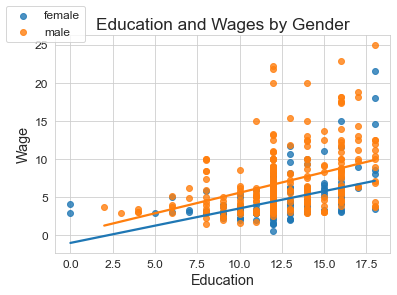

In [80]:
fig, ax = plt.subplots()
for gender in ['female', 'male']:
    sns.regplot(
        data=wages[wages.sex==gender], 
        x="educ", 
        y="wage", 
        label=gender,
        ci=None
    )
ax.set_title("Education and Wages by Gender")
ax.set_ylabel("Wage")
ax.set_xlabel("Education")
fig.legend(loc="upper left")

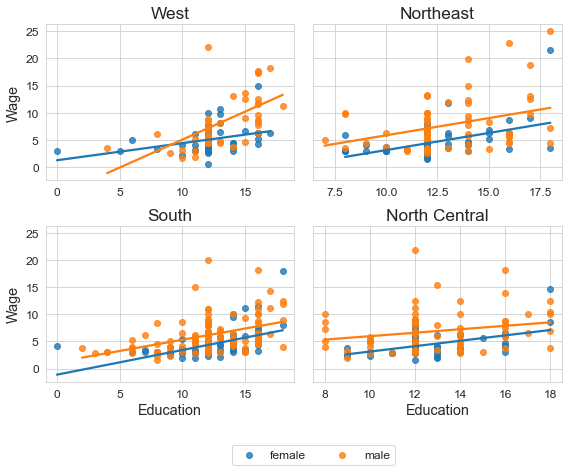

In [81]:
# change area names for next plot

wages['area'] = wages.area.map(
    {
        'northeast': 'Northeast',
        'northcen': 'North Central',
        'south': 'South',
        'west': 'West'
    }
)

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(8, 6))
(ax1, ax2), (ax3, ax4) = axes
for area, ax in zip(wages.area.unique(), (ax1, ax2, ax3, ax4)):
    for gender in ['female', 'male']:
        sns.regplot(
            data=wages[(wages.area==area) & (wages.sex==gender)], 
            x="educ", 
            y="wage", 
            label=gender if ax==ax1 else "",
            ci=None, 
            ax=ax
        )
    ax.set_title(area)
ax1.set_xlabel("")
ax1.set_ylabel("Wage")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax3.set_xlabel("Education")
ax3.set_ylabel("Wage")
ax4.set_xlabel("Education")
ax4.set_ylabel("")
fig.legend(bbox_to_anchor=(0.55, -0.1), loc='lower center', ncol=2)
fig.tight_layout()  
fig.savefig('test.pdf', bbox_inches='tight')